In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
%matplotlib inline
import json
import glob
import numpy as np
from PIL import Image
import rasterio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
from rasterio.plot import show_hist
#from scipy.misc import imsave
from imageio import imwrite
from sklearn.cluster import DBSCAN
from shapely.geometry import box
Image.MAX_IMAGE_PIXELS = None
import tifffile as tiff

In [56]:
liebre1_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebrepansharp.tif"
liebre1_box_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_boxes.geojson"

In [3]:
#visualise histogram:

rasterio_image = rasterio.open(liebre1_image_path)

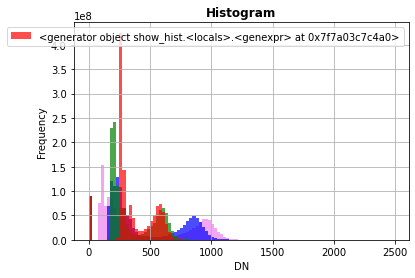

In [4]:
show_hist(rasterio_image, bins = 100 , lw=0.0, stacked = False, alpha=0.7, histtype= 'stepfilled')

In [57]:
#image_array = tiff.imread(liebre1_image_path)
image_array = rasterio_image.read()

In [58]:
print(image_array.max())
#image_array

2486


In [59]:
#read in arrays in each rgb band 
red = rasterio_image.read(1)
green = rasterio_image.read(2)
blue = rasterio_image.read(3)

In [60]:
#chack shapes and max/min values)
print(red.shape, green.shape, blue.shape)
print(red.max(),red.min())
print(green.max(),green.min())
print(blue.max(),blue.min())

(32768, 39355) (32768, 39355) (32768, 39355)
1850 0
1804 0
2309 0


In [64]:
red_95th = np.percentile(red,95)
green_95th = np.percentile(green,95)
blue_95th = np.percentile(blue,95)
print(red_95th,green_95th,blue_95th)

620.0 650.0 925.0


In [65]:
#norm_array = (image_array - image_array.min())/(image_array.max()-image_array.min())*image_array.max()

#scales the values to between 0 and 65535
#norm_red = (red)*(65535/red.max())
#norm_green = green*(65535/green.max())
#norm_blue = blue*(65535/blue.max())

#try scaling to between 0 and 255 using 95th percentile
norm_red = (red)*(255/red_95th)     #red.max())
norm_green = green*(255/green_95th) #green.max())
norm_blue = blue*(255/blue_95th)     #blue.max())

In [66]:
norm_red


array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 226.20967742,
        224.97580645, 210.99193548],
       [  0.        ,   0.        ,   0.        , ..., 216.33870968,
        195.77419355, 193.30645161],
       [  0.        ,   0.        ,   0.        , ..., 202.35483871,
        179.73387097, 196.59677419]])

In [67]:
print(norm_red.min(), norm_red.max())

0.0 760.8870967741935


In [68]:
rgb = np.dstack((norm_blue, norm_green, norm_red))
rgb.shape
#rgba_array = np.uint8(norm_array)


(32768, 39355, 3)

In [69]:
uint8_rgb = np.uint8(rgb)

In [70]:
uint8_rgb.max()

255

In [71]:
PIL_image = Image.fromarray(np.uint8(rgb))

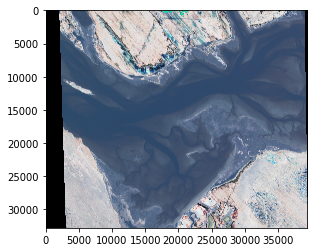

In [72]:
plt.imshow(PIL_image)

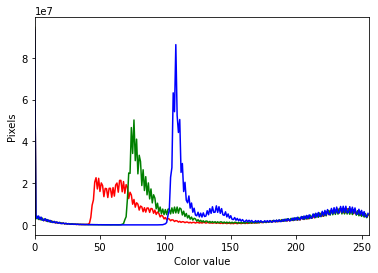

In [73]:
# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        uint8_rgb[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

In [74]:
from src.preprocessing.dataprocessing import convert_coords, save_files, read_coords

In [75]:
geotif = rasterio.open(liebre1_image_path)

In [76]:
file_save_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/norm_im_test"

<class 'PIL.Image.Image'>


KeyboardInterrupt: 

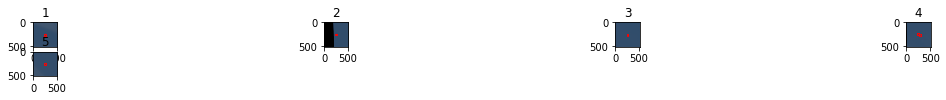

In [77]:
with open(liebre1_box_path, 'r') as f:
    label = json.load(f)
    image = PIL_image
    print(type(image))

    coords, centres = read_coords(label)
    
    # convert bounding box coordinates from geographic to image-scaled
    centres_converted = np.array([convert_coords(image, geotif, label, point[0], point[1]) for point in centres])
    
    coords_converted = np.array([[convert_coords(image, geotif, label, point[0][0], point[0][1]), 
                                  convert_coords(image, geotif, label, point[1][0], point[1][1])] 
                            for point in coords
                       ])    
    
    ## DB-Scan algorithm for clustering ##
    
    eps = 250 # threshold distance between two points to be in the same 'neighbourhood'
    dbscan = DBSCAN(min_samples=1, eps=eps)
    y = dbscan.fit_predict(centres_converted)

    # storing coordinates of clusters, relative to boundaries of image (not tile)
    info = {}
    for i in range(y.max()+1):
        
        # calculate the max and min coords of all the bounding boxes in the cluster
        box_centres = centres_converted[np.where(y==i)[0]]
        min_x, max_x = box_centres[:, 0].min(), box_centres[:, 0].max()
        min_y, max_y = box_centres[:, 1].min(), box_centres[:, 1].max()
        
        # assign each cluster of objects as an item
        item = {}
        item['centre'] = [(min_x+max_x)//2, (min_y+max_y)//2]
        item['object_boxes'] = coords_converted[np.where(y==i)[0]].tolist()
        item['name'] = "whale"
        info[i] = item
        
        # add a line here to generalize to multiple categories:
        # if label['features']['NumShip'] == ... : 

    save_files(image, label, info, file_save_path, 'liebre1norm')

In [78]:
#Visualise some of the saved files:
cropped_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/norm_im_test/liebre1norm_0.png"
cropped_label_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/norm_im_test/liebre1norm_0.txt"

In [79]:
cropped_image = Image.open(cropped_image_path)

In [80]:
import pandas as pd 
boxes = pd.read_csv(cropped_label_path, sep=" ", header=None)

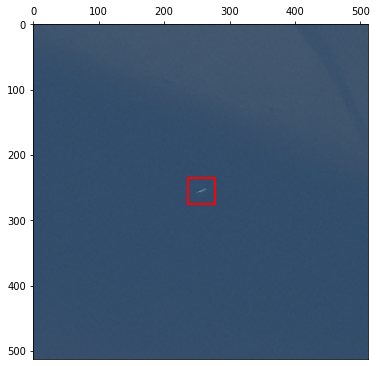

In [81]:
x = (boxes[1][0] - boxes[3][0]*0.5)*cropped_image.size[0]
y = (boxes[2][0] - boxes[4][0]*0.5)*cropped_image.size[1]
w = boxes[3][0] * cropped_image.size[0]
h = boxes[4][0] * cropped_image.size[1]
fig, ax = plt.subplots(figsize = (6,9))
ax.xaxis.tick_top()
ax.imshow(cropped_image)
ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

In [82]:
cropped_image_array = np.array(cropped_image)

In [83]:
cropped_image_array

array([[[ 62,  84, 113],
        [ 64,  86, 115],
        [ 62,  84, 113],
        ...,
        [ 65,  88, 114],
        [ 64,  87, 113],
        [ 61,  83, 108]],

       [[ 61,  82, 111],
        [ 62,  83, 111],
        [ 60,  80, 109],
        ...,
        [ 63,  86, 112],
        [ 60,  81, 107],
        [ 63,  86, 112]],

       [[ 63,  85, 113],
        [ 60,  80, 109],
        [ 61,  82, 111],
        ...,
        [ 63,  86, 111],
        [ 63,  85, 111],
        [ 64,  87, 112]],

       ...,

       [[ 54,  78, 108],
        [ 56,  81, 111],
        [ 53,  78, 107],
        ...,
        [ 50,  78, 107],
        [ 52,  81, 111],
        [ 51,  79, 108]],

       [[ 55,  80, 109],
        [ 54,  78, 107],
        [ 53,  77, 106],
        ...,
        [ 50,  78, 107],
        [ 49,  77, 106],
        [ 52,  80, 110]],

       [[ 53,  77, 106],
        [ 54,  79, 108],
        [ 54,  78, 108],
        ...,
        [ 52,  81, 110],
        [ 51,  79, 108],
        [ 49,  76, 105]]

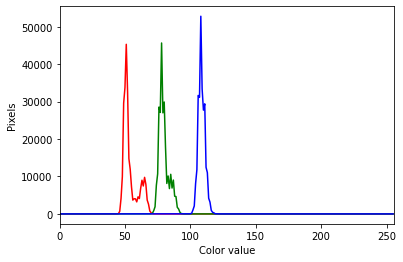

In [84]:
# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        cropped_image_array[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()